# Project Milestone Two: Modeling and Feature Engineering

### Due: Midnight on April 13 (with 2-hour grace period) and worth 25 points

### Overview

This milestone builds on your work from Milestone 1. You will:

1. Evaluate baseline models using default settings.
2. Engineer new features and re-evaluate models.
3. Use feature selection techniques to find promising subsets.
4. Select the top 3 models and fine-tune them for optimal performance.

You must do all work in this notebook and upload to your team leader's account in Gradescope. There is no
Individual Assessment for this Milestone. 


In [1]:
# ===================================
# Useful Imports: Add more as needed
# ===================================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars
import seaborn as sns

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# Progress Tracking

from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Load your Preprocessed Dataset from Milestone 1

In Milestone 1, you handled missing values, encoded categorical features, and explored your data. Before you begin this milestone, you’ll need to load that cleaned dataset and prepare it for modeling.

Here’s what to do:

1. Return to your Milestone 1 notebook and rerun your code through Part 3, where your dataset was fully cleaned (assume it’s called `df_cleaned`).

2. **Save** the cleaned dataset to a file by running:

>   df_cleaned.to_csv("zillow_cleaned.csv", index=False)

3. Switch to this notebook and **load** the saved data:

>   df = pd.read_csv("zillow_cleaned.csv")

4. Create a **train/test split** using `train_test_split`.  
   
6. **Standardize** the features (but not the target!) using **only the training data.** This ensures consistency across models without introducing data leakage from the test set:

>   scaler = StandardScaler()   
>   X_train_scaled = scaler.fit_transform(X_train)    
  
**Notes:** 

- You will not use the testing set during this milestone — it’s reserved for final evaluation later.
- You will have to redo the scaling step when you introduce new features (which have to be scaled as well).


In [2]:
df = pd.read_csv("zillow_cleaned.csv")
X = df.drop(columns=["taxvaluedollarcnt"])
y = df["taxvaluedollarcnt"]

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=random_state)

In [4]:
scaler = StandardScaler()   
X_train_scaled = scaler.fit_transform(X_train)

### Part 1: Baseline Modeling [3 pts]

Apply the following regression models to the scaled training dataset using **default parameters**:

- Linear Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Bagging
- Random Forest
- Gradient Boosting Trees

For each model:
- Use **repeated cross-validation** (e.g., 5 folds, 5 repeats).
- Report the **mean and standard deviation of CV RMSE Score** across all folds in a table. 


In [5]:
# Repeated cross-validation with default 5 folds and 10 repeats
repeated_cv = RepeatedKFold(random_state=random_state)

models = [LinearRegression(), 
          Ridge(random_state=random_state), 
          Lasso(random_state=random_state), 
          DecisionTreeRegressor(random_state=random_state), 
          BaggingRegressor(random_state=random_state), 
          RandomForestRegressor(random_state=random_state), 
          GradientBoostingRegressor(random_state=random_state)]

In [5]:
baseline_means = []
baseline_std = []

start = time.time()

for model in models:
    cv_rmse_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, cv=repeated_cv, scoring="neg_mean_squared_error", n_jobs=4))
    mean_cv_rmse = np.mean(cv_rmse_scores)
    std_cv = np.std(cv_rmse_scores)
    
    baseline_means.append(dollar_format(mean_cv_rmse, 0))
    baseline_std.append(dollar_format(std_cv, 0))

end = time.time()

baseline_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge", "Lasso", "Decision Tree", "Bagging Regressor", "Random Forest", "Gradient Boosting"],
    "Mean RMSE": baseline_means,
    "Std RMSE": baseline_std
})

format_hms(end - start)

'00:06:59'

In [6]:
baseline_df

,Model,Mean RMSE,Std RMSE
0,Linear Regression,"$319,442","$4,195"
1,Ridge,"$319,442","$4,195"
2,Lasso,"$319,442","$4,195"
3,Decision Tree,"$389,703","$5,343"
4,Bagging Regressor,"$294,504","$3,965"
5,Random Forest,"$282,642","$3,397"
6,Gradient Boosting,"$287,794","$3,682"


In [7]:
# Sort by Mean RMSE
baseline_df = baseline_df.sort_values("Mean RMSE")

# Display nicely
print("--- Baseline Model Performance ---")
print(baseline_df.to_string(index=False))

--- Baseline Model Performance ---
            Model Mean RMSE Std RMSE
    Random Forest  $282,642   $3,397
Gradient Boosting  $287,794   $3,682
Bagging Regressor  $294,504   $3,965
Linear Regression  $319,442   $4,195
            Ridge  $319,442   $4,195
            Lasso  $319,442   $4,195
    Decision Tree  $389,703   $5,343


### Part 1: Discussion [2 pts]

In a paragraph or well-organized set of bullet points, briefly compare and discuss:

  - Which models perform best overall?
  - Which are most stable (lowest std)?
  - Any signs of overfitting or underfitting?

Among the baseline models, Random Forest achieved the best performance with the lowest mean RMSE of approximately `$282,642`, followed closely by Gradient Boosting and Bagging. These tree-based ensemble models clearly outperformed the linear models, which all had nearly identical RMSEs around `$319,442`, indicating limited predictive power under default settings. In terms of stability, Random Forest also had the lowest standard deviation across cross-validation folds, suggesting it provides both strong and consistent performance. On the other hand, the linear models (Linear Regression, Ridge, and Lasso) showed signs of underfitting, as they failed to capture the complexity in the data and yielded much higher RMSEs. The Decision Tree model performed the worst with the highest RMSE of `$389,703` and a higher standard deviation of `$5,343` across folds with potential overfitting.

### Part 2: Feature Engineering [3 pts]

Consider **at least three new features** based on your Milestone 1, Part 5. Examples include:
- Polynomial terms
- Log or interaction terms
- Groupings or transformations of categorical features

Add these features to `X_train` and then:
- Scale using `StandardScaler` 
- Re-run all models listed above (using default settings again).
- Report updated RMSE scores (mean and std) across repeated CV in a table. 

**Note:**  Recall that this will require creating a new version of the dataset, so effectively you may be running "polynomial regression" using `LinearRegression`. 

In [6]:
# Add polynomial terms
X_train["sqft_squared"] = X_train["calculatedfinishedsquarefeet"] ** 2
X_train["sqft_bathroom_interaction"] = X_train["calculatedfinishedsquarefeet"] * X_train["bathroomcnt"]

# Add log terms
X_train["log_finishedsquarefeet12"] = np.log(X_train["finishedsquarefeet12"])
X_train["log_calculatedfinishedsquarefeet"] = np.log(X_train["calculatedfinishedsquarefeet"])

X_train = X_train.reset_index(drop=True)

# Scale using StandardScaler
X_train_scaled = scaler.fit_transform(X_train)

In [7]:
# For future usage
X_test["sqft_squared"] = X_test["calculatedfinishedsquarefeet"] ** 2
X_test["sqft_bathroom_interaction"] = X_test["calculatedfinishedsquarefeet"] * X_test["bathroomcnt"]

X_test["log_finishedsquarefeet12"] = np.log(X_test["finishedsquarefeet12"])
X_test["log_calculatedfinishedsquarefeet"] = np.log(X_test["calculatedfinishedsquarefeet"])

X_test = X_test.reset_index(drop=True)

X_test_scaled = scaler.transform(X_test)

In [9]:
added_features_means = []
added_features_std = []

start = time.time()

for model in models:
    cv_rmse_scores = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, cv=repeated_cv, scoring="neg_mean_squared_error", n_jobs=4))
    mean_cv_rmse = np.mean(cv_rmse_scores)
    std_cv = np.std(cv_rmse_scores)
    
    added_features_means.append(dollar_format(mean_cv_rmse, 0))
    added_features_std.append(dollar_format(std_cv, 0))

end = time.time()

added_features_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge", "Lasso", "Decision Tree", "Bagging Regressor", "Random Forest", "Gradient Boosting"],
    "Mean RMSE": added_features_means,
    "Std RMSE": added_features_std
})

format_hms(end - start)

/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e+15, tolerance: 9.002e+11
  model = cd_fast.enet_coordinate_descent(
/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e+15, tolerance: 8.802e+11
  model = cd_fast.enet_coordinate_descent(
/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

'00:10:35'

In [10]:
added_features_df

,Model,Mean RMSE,Std RMSE
0,Linear Regression,"$316,602","$3,897"
1,Ridge,"$316,601","$3,898"
2,Lasso,"$316,595","$3,899"
3,Decision Tree,"$390,883","$5,580"
4,Bagging Regressor,"$294,267","$3,666"
5,Random Forest,"$282,407","$3,386"
6,Gradient Boosting,"$287,948","$3,686"


In [15]:
# Sort by Mean RMSE
added_features_df = added_features_df.sort_values("Mean RMSE")

# Display nicely
print("--- Added Features Model Performance ---")
print(added_features_df.to_string(index=False))

--- Added Features Model Performance ---
            Model Mean RMSE Std RMSE
    Random Forest  $282,407   $3,386
Gradient Boosting  $287,948   $3,686
Bagging Regressor  $294,267   $3,666
            Lasso  $316,595   $3,899
            Ridge  $316,601   $3,898
Linear Regression  $316,602   $3,897
    Decision Tree  $390,883   $5,580


### Part 2: Discussion [2 pts]

Reflect on the impact of your new features:

- Did any models show notable improvement in performance?

- Which new features seemed to help — and in which models?

- Do you have any hypotheses about why a particular feature helped (or didn’t)?

- Were there any unexpected results?



After applying feature engineering, there was a notable improvement in the linear models. The mean RMSEs of the linear models decreased by a few thousand dollars and the standard deviation decreased by a few hundred dollars. The other notable improvement was the standard deviation of the bagging regressor decreasing by a few hundred as well. The rest of the models did not change by much in both the mean RMSE and the standard deviation. We believe that both the polynomial terms and the log-transformed terms added were the reasons why the linear models improved. It allowed the simple underfitting linear models to capture nonlinear relationships and the skewness in features with exponential characteristics. We expected not much change to the ensemble tree models due to the models already being able to capture nonlinear relationships and deal with skewness in features.

### Part 3: Feature Selection [3 pts]

Using the full set of features (original + engineered):
- Apply **feature selection** methods to investigate whether you can improve performance.
  - You may use forward selection, backward selection, or feature importance from tree-based models.
- For each model, identify the **best-performing subset of features**.
- Re-run each model using only those features.
- Report updated RMSE scores (mean and std) across repeated CV in a table.


In [12]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv=5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = np.sqrt(cv_score)

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score:
            best_score = current_score
            best_feature_set = selected_features.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return (
        selected_features,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score              # The best CV score
    )

In [13]:
best_feature_sets = []
best_cv_rmse_scores = []

start = time.time()

for model in tqdm(models, desc="Performing Feature Selection"):
    selected_features, best_scores, best_feature_set, best_score = forward_feature_selection(pd.DataFrame(X_train_scaled, columns=X_train.columns), y_train, model, n_jobs=3)
    best_feature_sets.append(best_feature_set)
    best_cv_rmse_scores.append(dollar_format(best_score,0))

feature_selection_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge", "Lasso", "Decision Tree", "Bagging Regressor", "Random Forest", "Gradient Boosting"],
    "Best Feature Set": best_feature_sets,
    "Best CV RMSE Score": best_cv_rmse_scores
})

end = time.time()
format_hms(end - start)

Performing Feature Selection:  29%|███████████████▋                                       | 2/7 [01:06<02:44, 32.82s/it]/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.258e+11, tolerance: 8.975e+11
  model = cd_fast.enet_coordinate_descent(
/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+12, tolerance: 8.910e+11
  model = cd_fast.enet_coordinate_descent(
/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might

'02:14:31'

In [24]:
feature_selection_df.sort_values("Best CV RMSE Score").reset_index(drop=True)

,Model,Best Feature Set,Best CV RMSE Score
0,Random Forest,"[regionidzip, bathroomcnt, propertylandusetype...","$282,555"
1,Gradient Boosting,"[finishedsquarefeet12, regionidzip, yearbuilt,...","$287,822"
2,Bagging Regressor,"[regionidzip, bathroomcnt, propertylandusetype...","$294,213"
3,Decision Tree,"[regionidzip, calculatedbathnbr, propertylandu...","$306,732"
4,Ridge,"[finishedsquarefeet12, regionidzip, buildingqu...","$316,473"
5,Linear Regression,"[finishedsquarefeet12, regionidzip, buildingqu...","$316,474"
6,Lasso,"[finishedsquarefeet12, regionidzip, buildingqu...","$316,474"


In [22]:
for i, model in enumerate(models):
    print(model)
    print(feature_selection_df.loc[i, "Best Feature Set"])

LinearRegression()
['finishedsquarefeet12', 'regionidzip', 'buildingqualitytypeid', 'sqft_bathroom_interaction', 'bedroomcnt', 'regionidcounty', 'roomcnt', 'propertylandusetypeid', 'fips', 'regionidcity', 'propertycountylandusecode', 'calculatedfinishedsquarefeet', 'sqft_squared', 'log_calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet', 'propertyzoningdesc', 'heatingorsystemtypeid', 'fullbathcnt', 'calculatedbathnbr']
Ridge(random_state=42)
['finishedsquarefeet12', 'regionidzip', 'buildingqualitytypeid', 'sqft_bathroom_interaction', 'bedroomcnt', 'regionidcounty', 'roomcnt', 'propertylandusetypeid', 'fips', 'regionidcity', 'propertycountylandusecode', 'calculatedfinishedsquarefeet', 'sqft_squared', 'log_calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet', 'propertyzoningdesc', 'heatingorsystemtypeid', 'fullbathcnt', 'calculatedbathnbr']
Lasso(random_state=42)
['finishedsquarefeet12', 'regionidzip', 'buildingqualitytypeid', 'sqft_bathroom_interaction', 'bedroomc

In [25]:
feature_selection_means = []
feature_selection_stds = []

start = time.time()

for model, best_feature_set in zip(models, best_feature_sets):
    cv_rmse_scores = np.sqrt(-cross_val_score(model, pd.DataFrame(X_train_scaled, columns=X_train.columns)[best_feature_set], y_train, cv=repeated_cv, scoring="neg_mean_squared_error", n_jobs=3))
    mean_cv_rmse = np.mean(cv_rmse_scores)
    std_cv = np.std(cv_rmse_scores)
    
    feature_selection_means.append(dollar_format(mean_cv_rmse, 0))
    feature_selection_stds.append(dollar_format(std_cv, 0))
    
end = time.time()

feature_selection_df = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge", "Lasso", "Decision Tree", "Bagging Regressor", "Random Forest", "Gradient Boosting"],
    "Mean RMSE": feature_selection_means,
    "Std RMSE": feature_selection_stds
})

format_hms(end - start)

/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.069e+11, tolerance: 8.802e+11
  model = cd_fast.enet_coordinate_descent(
/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.100e+11, tolerance: 8.916e+11
  model = cd_fast.enet_coordinate_descent(
/home/jason8924/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duali

'00:09:30'

In [28]:
# Sort by Mean RMSE
feature_selection_df = feature_selection_df.sort_values("Mean RMSE")

# Display nicely
print("--- Feature Selection Model Performance ---")
print(feature_selection_df.to_string(index=False))

--- Feature Selection Model Performance ---
            Model Mean RMSE Std RMSE
    Random Forest  $282,817   $3,291
Gradient Boosting  $287,757   $3,721
Bagging Regressor  $294,677   $4,016
    Decision Tree  $307,249   $4,105
Linear Regression  $316,452   $3,944
            Ridge  $316,452   $3,944
            Lasso  $316,452   $3,944


### Part 3: Discussion [2 pts]

Analyze the effect of feature selection on your models:

- Did performance improve for any models after reducing the number of features?

- Which features were consistently retained across models?

- Were any of your newly engineered features selected as important?

- How did feature selection differ between linear and tree-based models?

> Your text here

### Part 4: Fine-Tuning Your Top 3 Models [6 pts]

In this final phase of Milestone 2, you’ll select and refine your **three most promising models and their corresponding data pipelines** based on everything you've done so far.

1. Choose the top 3 models based on performance and interpretability from earlier parts.
2. For each model:
   - Perform hyperparameter tuning using `sweep_parameters`, `GridSearchCV`, `RandomizedSearchCV`, or other techniques from previous homeworks. 
   - Experiment with different versions of your feature engineering and preprocessing — treat these as additional tunable components.
3. Report the mean and standard deviation of CV RMSE score for each model in a summary table.



In [8]:
# Taken from homework 7
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument. 
    if isinstance(model, type):
        model = model(**model_params)

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), n_jobs  = n_jobs)
    
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse

def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    no_improve_count = 0
    best_mse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('MSE_found', None)
        
        cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
        test_mses.append(test_mse)
        
        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_mse = min(cv_mses)
    min_index = cv_mses.index(min_cv_mse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MSE_found'] = min_cv_mse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_mses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 np.sqrt(cv_mses) if show_rmse else cv_mses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 np.sqrt(train_mses) if show_rmse else train_mses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.plot(x_vals,
                 np.sqrt(test_mses) if show_rmse else test_mses,
                 linestyle='--', label=f"Test {error_name}", color='orange')
        ax1.scatter([x_vals[min_index]],
                    [np.sqrt(min_cv_mse) if show_rmse else min_cv_mse],
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


In [10]:
# Taken from homework 7
# Define the parameters for the Random Forest

Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
    'MSE_found'   : float('inf') # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                 # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

In [11]:
rf_X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)[['regionidzip', 'bathroomcnt', 'propertylandusetypeid', 'fullbathcnt', 'regionidcounty', 'fips', 'calculatedbathnbr', 'unitcnt', 'regionidcity', 'calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertyzoningdesc', 'roomcnt', 'buildingqualitytypeid', 'bedroomcnt', 'heatingorsystemtypeid', 'sqft_squared']]
rf_X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)[['regionidzip', 'bathroomcnt', 'propertylandusetypeid', 'fullbathcnt', 'regionidcounty', 'fips', 'calculatedbathnbr', 'unitcnt', 'regionidcity', 'calculatedfinishedsquarefeet', 'yearbuilt', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertyzoningdesc', 'roomcnt', 'buildingqualitytypeid', 'bedroomcnt', 'heatingorsystemtypeid', 'sqft_squared']]

Sweeping n_estimators: 100%|█████████████████████████████████████████████████████████████| 9/9 [59:24<00:00, 396.05s/it]


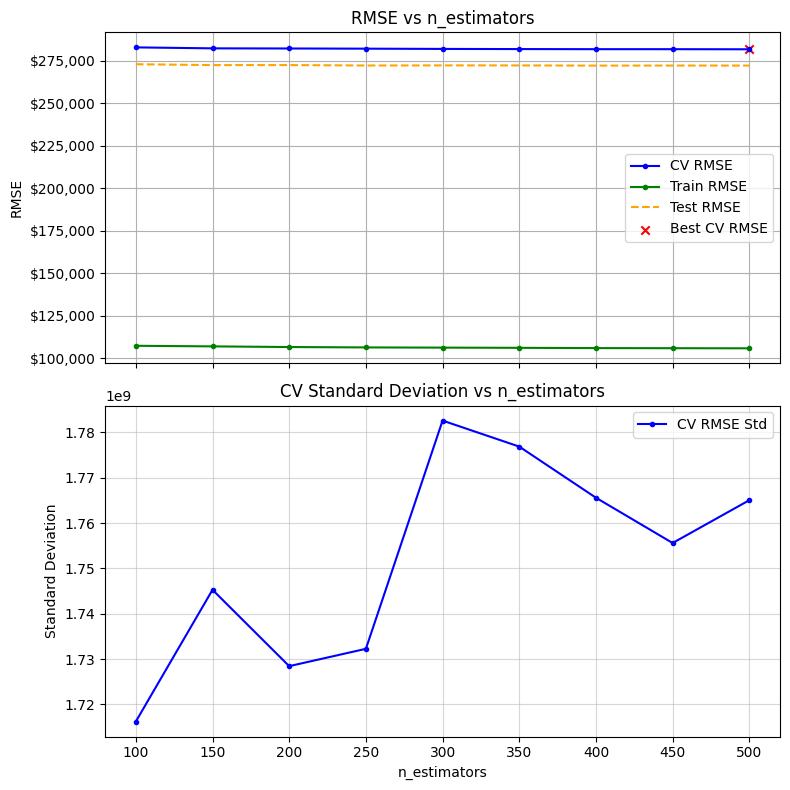

Execution Time: 00:59:24


In [45]:
# Initial wide sweep on n_estimators
Parameters_BT = Default_Parameters_Random_Forests.copy()
Parameters_BT = sweep_parameter(RandomForestRegressor, Parameters_BT, "n_estimators", range(100,501,50), n_jobs=3, X_train=rf_X_train, X_test=rf_X_test, n_repeats=2)

Sweeping max_features:  16%|█████████▋                                                   | 3/19 [02:51<16:16, 61.02s/it]/home/jason8924/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_features: 100%|█████████████████████████████████████████████████████████| 19/19 [1:10:48<00:00, 223.61s/it]


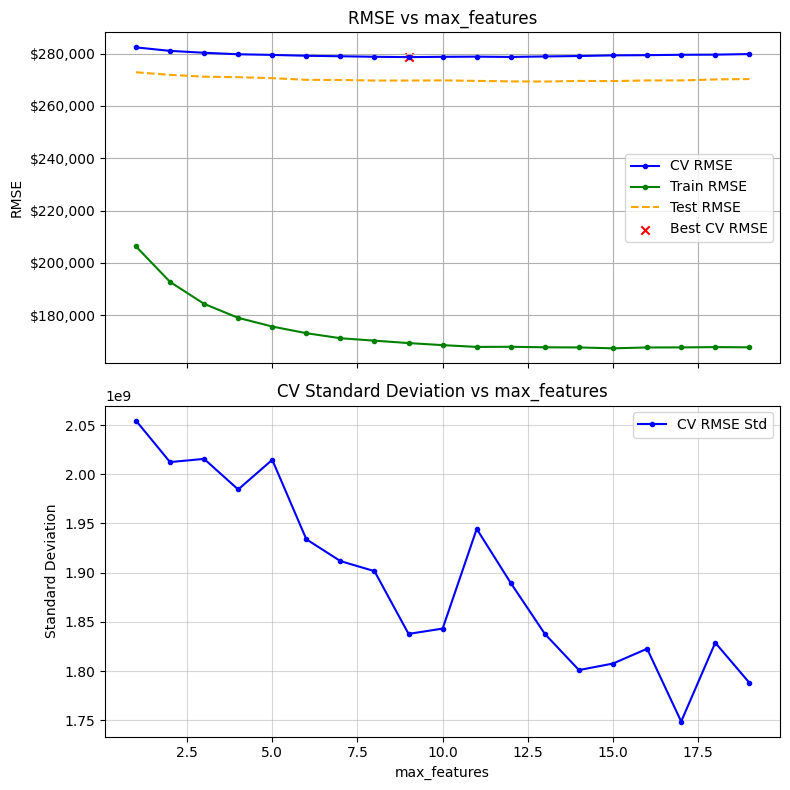

Execution Time: 01:10:48


In [13]:
Parameters_BT = sweep_parameter(RandomForestRegressor, Parameters_BT, "max_features", range(1,20,1), n_jobs=4, X_train=rf_X_train, X_test=rf_X_test, n_repeats=2)

Sweeping max_depth: 100%|██████████████████████████████████████████████████████████████| 10/10 [54:31<00:00, 327.15s/it]


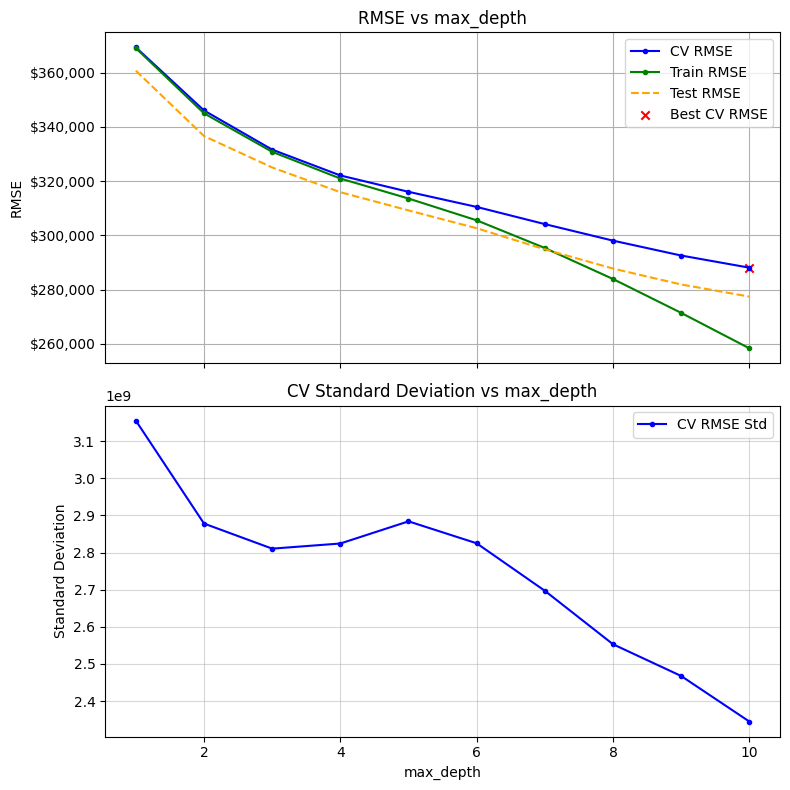

Execution Time: 00:54:31


In [55]:
Parameters_BT = sweep_parameter(RandomForestRegressor, Parameters_BT, "max_depth", range(1,11,1), n_jobs=3, X_train=rf_X_train, X_test=rf_X_test, n_repeats=5)

Sweeping max_depth:  60%|█████████████████████████████████████▊                         | 6/10 [47:23<33:40, 505.04s/it]/home/jason8924/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_depth:  80%|████████████████████████████████████████████████▊            | 8/10 [1:07:10<18:26, 553.20s/it]/home/jason8924/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping max_depth:  90%|██████████████████████████████████████████████████████▉      | 9/10 [1:17:17<09:30, 570.14s/it]/home/jason8924/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker

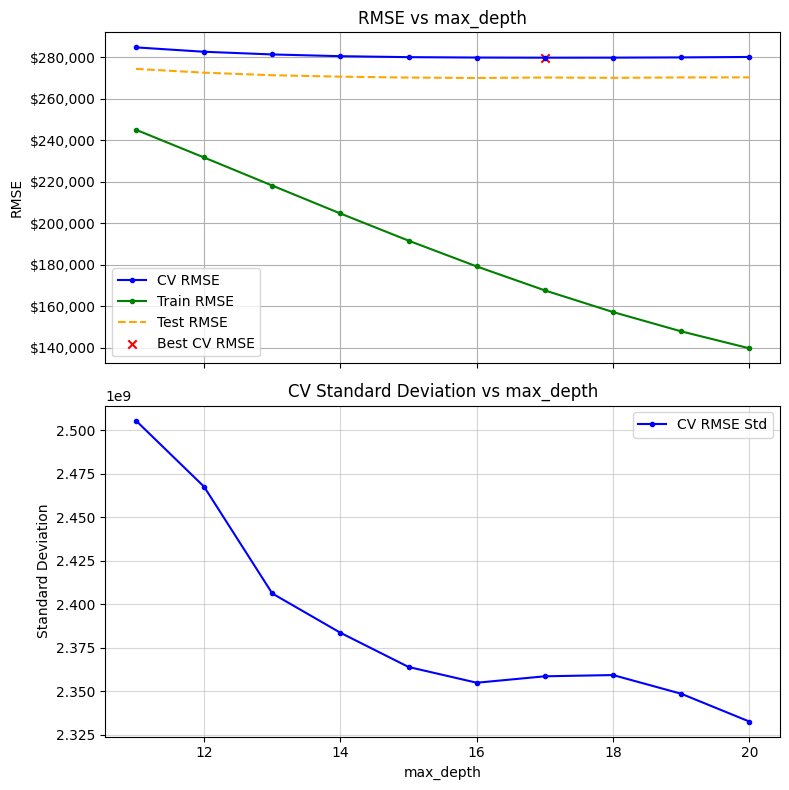

Execution Time: 01:28:07


In [56]:
Parameters_BT = sweep_parameter(RandomForestRegressor, Parameters_BT, "max_depth", range(11,21,1), n_jobs=3, X_train=rf_X_train, X_test=rf_X_test, n_repeats=3)

Sweeping bootstrap:   0%|                                                                         | 0/2 [00:00<?, ?it/s]/home/jason8924/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping bootstrap:  50%|███████████████████████████████▌                               | 1/2 [19:29<19:29, 1169.71s/it]/home/jason8924/.local/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Sweeping bootstrap: 100%|████████████████████████████████████████████████████████████████| 2/2 [32:50<00:00, 985.49s/it]


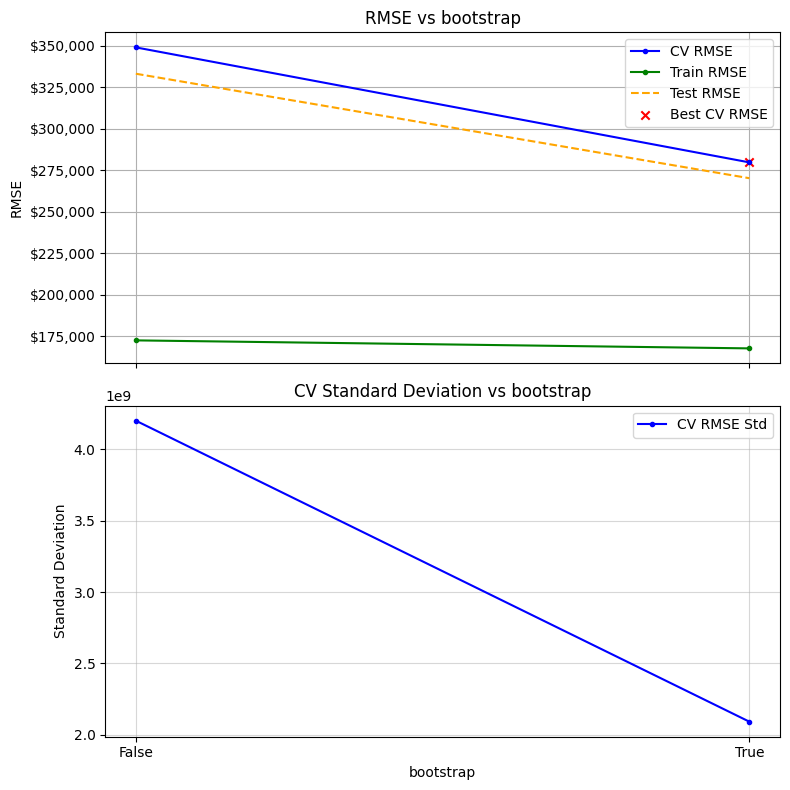

Execution Time: 00:32:51


In [60]:
Parameters_BT = sweep_parameter(RandomForestRegressor, Parameters_BT, "bootstrap", [False, True], n_jobs=4, X_train=rf_X_train, X_test=rf_X_test, n_repeats=5)

In [15]:
Parameters_BT

{'n_estimators': 500,
 'max_features': 9,
 'max_depth': 17,
 'bootstrap': True,
 'random_state': 42,
 'MSE_found': np.float64(77654896611.76492)}

In [16]:
np.sqrt(77654896611.76492)

np.float64(278666.28179915296)

### Part 4: Discussion [4 pts]

Reflect on your tuning process and final results:

- What was your tuning strategy for each model? Why did you choose those hyperparameters?
- Did you find that certain types of preprocessing or feature engineering worked better with specific models?
- Provide a ranking of your three models and explain your reasoning — not just based on RMSE, but also interpretability, training time, or generalizability.
- Conclude by considering whether this workflow has produced the results you expected. Typically, you would repeat steps 2 - 4 and also reconsider the choices you made in Milestone 1 when cleaning the dataset, until reaching the point of diminishing returns; do you think that would that have helped here?

> Your text here